In [168]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import numpy 

useMedianFilter = True
useHistogramEqualisation = False
fileSuffix = ''
#fileSuffix = '_noAug'
#fileSuffix = '_Median_'+str(useMedianFilter) + 'HistogramEq_'+str(useHistogramEqualisation)

# Read Actual Bounding Boxes

In [33]:
file = open('../Data/Source_Images/Test_Images/data_test.txt', 'r')
file_names = []
xmin = []
ymin = []
xmax = []
ymax = []

line = file.readline()
while line:
    line_split = line.split()
    
    boxes = line_split[1:]
    for i in range(0, len(boxes)):
        boxes[i] = list(map(int, boxes[i].split(',')))
        file_names.append(line_split[0].split('/')[-1]) 
        xmin.append(boxes[i][0])
        ymin.append(boxes[i][1])
        xmax.append(boxes[i][2])
        ymax.append(boxes[i][3])

    line = file.readline()        
file.close()

actual = pd.DataFrame({'image': file_names,
                       'xmin': xmin,
                       'ymin': ymin,
                       'xmax': xmax,
                       'ymax': ymax})
actual

,image,xmin,ymin,xmax,ymax
0,2b8f6d6d9c1bfe38.jpg,375,274,429,342
1,2b930250623e3c86.jpg,944,524,1018,614
2,2b95c8153c8ffd15.jpg,289,220,306,249
3,2b9b05cb2195e0aa.jpg,606,216,759,402
4,2b9b05cb2195e0aa.jpg,967,319,1022,378
...,...,...,...,...,...
1072,301f23b2cf223b36.jpg,590,360,785,524
1073,301f23b2cf223b36.jpg,737,290,835,402
1074,301f23b2cf223b36.jpg,789,402,943,600
1075,3021812c3f941a9c.jpg,203,123,584,625


# Read Predicted Bounding Boxes

In [169]:
predicted = pd.read_csv('../Data/Source_Images/Test_Image_Detection_Results/Detection_Results'+fileSuffix+'.csv')
predicted

,image,image_path,xmin,ymin,xmax,ymax,label,confidence,x_size,y_size
0,2b8f6d6d9c1bfe38.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,373,272,425,333,0,0.279940,1024,768
1,2b8f6d6d9c1bfe38.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,0,288,34,352,0,0.286684,1024,768
2,2b8f6d6d9c1bfe38.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,600,261,670,339,0,0.390067,1024,768
3,2b8f6d6d9c1bfe38.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,450,273,597,441,0,0.785798,1024,768
4,2b95c8153c8ffd15.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,627,261,660,296,0,0.359383,1024,682
...,...,...,...,...,...,...,...,...,...,...
1281,307d5ac16ddbebda.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,147,114,353,347,0,0.253806,1024,683
1282,307d5ac16ddbebda.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,656,130,878,360,0,0.645945,1024,683
1283,3082acf9014751d3.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,490,187,567,271,0,0.310143,1024,768
1284,3082acf9014751d3.jpg,C:\Users\Simone\Desktop\COV\Projekt\head_detec...,246,125,397,294,0,0.416224,1024,768


# Evaluate (Intersection Over Union)

In [149]:
def bb_intersection_over_union(boxesA, boxesB):
    ious = []
    for boxA in boxesA.iterrows():
        boxA_ious = []
        boxA = boxA[1]
        
        for boxB in boxesB.iterrows():
            boxB = boxB[1]

            xA = max(boxA['xmin'], boxB['xmin'])
            yA = max(boxA['ymin'], boxB['ymin'])
            xB = min(boxA['xmax'], boxB['xmax'])
            yB = min(boxA['ymax'], boxB['ymax'])

            inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxA_area = (boxA['xmax'] - boxA['xmin'] + 1) * (boxA['ymax'] - boxA['ymin'] + 1)
            boxB_area = (boxB['xmax'] - boxB['xmin'] + 1) * (boxB['ymax'] - boxB['ymin'] + 1)
            
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
            iou = inter_area / float(boxA_area + boxB_area - inter_area)
            
            boxA_ious.append(iou)
            
        
        if (len(boxA_ious) == 0):
            ious.append(0)
        else:
            ious.append(max(boxA_ious))
    
    return np.array(ious) 

In [170]:
ious = np.array([])
for file in actual['image'].unique():
    iou = bb_intersection_over_union(actual[actual['image'] == file], predicted[predicted['image'] == file])
    ious = np.concatenate((ious, iou), axis=None)
    
th = 0.4
tp = np.count_nonzero(ious >= th)
fn = np.count_nonzero(ious < th)

print(tp/(tp+fn))

# mean iou
print(np.mean(ious))

# zero intersection ratio
zero_ratio = (ious == 0).sum() / ious.shape[0]
#print(zero_ratio)

# non zero ratio
print(1 - zero_ratio)



0.7251624883936861
0.572190660508225
0.765088207985144


In [112]:
def plot_history(history_stage_1, history_final):
    loss_list_stage_1 = [s for s in history_stage_1.keys() if 'loss' in s and 'val' not in s]
    val_loss_list_stage_1 = [s for s in history_stage_1.keys() if 'loss' in s and 'val' in s]
    
    loss_list_final = [s for s in history_final.keys() if 'loss' in s and 'val' not in s]
    val_loss_list_final = [s for s in history_final.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list_stage_1) == 0 or len(loss_list_final) == 0:
        print('Loss is missing in history')
        return 
    
    epochs_stage_1 = range(1,len(history_stage_1[loss_list_stage_1[0]]) + 1)
    epochs_final = range(1,len(history_final[loss_list_final[0]]) + 1)
    
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(20, 6))
    
    ## Loss
    for l in loss_list_stage_1:
        ax0.plot(epochs_stage_1, history_stage_1[l], 'b', label='Training loss (' + str(str(format(history_stage_1[l][-1],'.2f'))+')'))
    for l in val_loss_list_stage_1:
        ax0.plot(epochs_stage_1, history_stage_1[l], 'g', label='Validation loss (' + str(str(format(history_stage_1[l][-1],'.2f'))+')'))
    
    ax0.set_title('Loss stage 1', fontsize=18)
    ax0.set_xlabel('Epochs', fontsize=16)
    ax0.set_ylabel('Loss', fontsize=16)
    ax0.legend(prop={'size': 16},loc=1)
    
    for l in loss_list_final:
        ax1.plot(epochs_final, history_final[l], 'b', label='Training loss (' + str(str(format(history_final[l][-1],'.2f'))+')'))
    for l in val_loss_list_final:
        ax1.plot(epochs_final, history_final[l], 'g', label='Validation loss (' + str(str(format(history_final[l][-1],'.2f'))+')'))
    
    ax1.set_title('Loss final', fontsize=18)
    ax1.set_xlabel('Epochs', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.legend(prop={'size': 16},loc=1)
    
    
    for l in loss_list_final:
        ax2.plot(epochs_final, sp.signal.medfilt(history_final[l],3), 'b', label='Training loss (' + str(str(format(history_final[l][-1],'.2f'))+')'))
    for l in val_loss_list_final:
        ax2.plot(epochs_final,  sp.signal.medfilt(history_final[l],3), 'g', label='Validation loss (' + str(str(format(history_final[l][-1],'.2f'))+')'))
    
    ax2.set_title('Loss final filtered', fontsize=18)
    ax2.set_xlabel('Epochs', fontsize=16)
    ax2.set_ylabel('Loss', fontsize=16)
    ax2.legend(prop={'size': 16},loc=1)



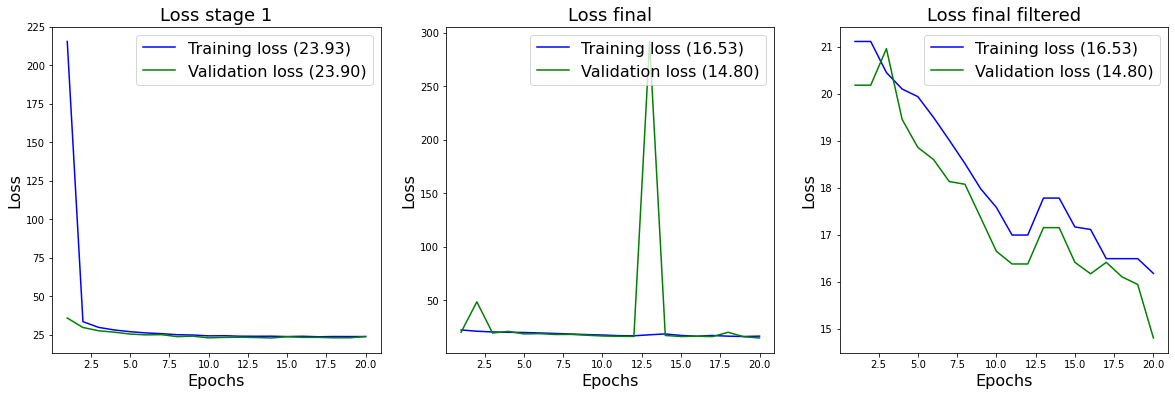

In [115]:
with open('../Data/Model_Weights/history_stage_1'+fileSuffix+'.pkl', 'rb') as history_file:
    history_stage_1 = pickle.load(history_file)
with open('../Data/Model_Weights/history_final'+fileSuffix+'.pkl', 'rb') as history_file:
    history_final = pickle.load(history_file)
plot_history(history_stage_1,history_final)